##임베딩 내 편향성 알아보기

개발 환경
<br/>데이터 정보

Word Embedding
<br/>Tokenizer
<br/>Word2Vec

Target-Attribute Word Set
<br/>WEAT(Word Embedding Association Test)
<br/>결론
<br/>참고문헌

#개발 환경

In [ ]:
%%bash
apt-get update
apt-get install g++ openjdk-8-jdk python-dev python3-dev
pip3 install JPype1
pip3 install konlpy

In [ ]:
%env JAVA_HOME "/usr/lib/jvm/java-8-openjdk-amd64"

Okt를 작동하기 위한 KoNLPy 환경을 구성한다.
<br/>bash 셸로 명령어 입력하여 라이브러리를 설치한다.<br/>JAVA_HOME 환경변수를 설정한다.

In [ ]:
!pip install gensim

In [ ]:
import os
import seaborn as sns
import matplotlib as plt
from matplotlib import font_manager as fm

In [ ]:
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
import konlpy
from konlpy.tag import Okt

In [ ]:
import gensim
from gensim.models import KeyedVectors
from gensim.models import Word2Vec

In [ ]:
import numpy as np
from numpy import dot
from numpy.linalg import norm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
pip freeze > '/content/drive/MyDrive/lms/library_version.txt'

In [ ]:
library_name = ['scikit-learn=', 'seaborn=', 'matplotlib=', 'konlpy=', 'gensim=', 'numpy=']
library_version = []
f = open('/content/drive/MyDrive/lms/library_version.txt', 'r')
line = f.readline()
while True:
    line = f.readline()
    if not line:
      break
    for i in library_name:
      if i in line:
        library_version.append(line)
        library_version.append('    ')

f.close()

import sys
print(sys.version)
print()

for i in range(0, len(library_version) - 1, 6):
  print(str(library_version[i : i+6]).replace("[","").replace("]","").replace("'","").replace("\\n","").replace(",",""), end='') 
  if i % 6 == 0:
    print()

for i in range(len(library_version) - 1):
  if (i-1) % 6 == 0 and i == len(library_version) - 6:
    print(str(library_version[-1]).replace("[","").replace("]","").replace("'","").replace("\\n","").replace(",",""), end='')

3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]

gensim==3.6.0      konlpy==0.6.0      matplotlib==3.2.2     
numpy==1.21.6      scikit-learn==1.0.2      seaborn==0.11.2     


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Google Colab에서 할당된 GPU를 확인한다.
<br/>고용량 메모리 VM에 액세스한다

#데이터 정보

[KOBIS 영화정보 시놉시스](https://www.kobis.or.kr/kobis/business/mast/mvie/searchMovieList.do)

KOBIS(영화관입장권통합전산망) 사이트에서
<br/>2001년부터 2019년 8월까지 제작된 영화의 시놉시스 정보를 수집했다.

In [ ]:
print(os.listdir('/content/drive/MyDrive/lms/weat_score/synopsis'))

['synopsis.txt', 'synopsis_art.txt', 'synopsis_gen.txt', 'synopsis_etc.txt', 'synopsis_SF.txt', 'synopsis_comedy.txt', 'synopsis_mystery.txt', 'synopsis_historical.txt', 'synopsis_documentary.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 'synopsis_western.txt', 'synopsis_crime.txt', 'synopsis_thriller.txt', 'synopsis_adult.txt', 'synopsis_drama.txt', 'synopsis_musical.txt', 'synopsis_fantasy.txt', 'synopsis_family.txt', 'synopsis_war.txt', 'synopsis_adventure.txt', 'synopsis_romance.txt', 'synopsis_show.txt', 'synopsis_horror.txt']


[synopsis](https://d3s0tskafalll9.cloudfront.net/media/documents/synopsis.zip)

영화 구분과 장르 구분에 따라 시놉시스가 분류된다.
<br/>KOBIS에서 제공한 정보를 기준으로 분류한다.

영화 구분 정보는 일반영화(gen), 예술영화(art)로 구분된 정보이다.

장르 구분 정보는 SF, 가족(family), 공연(sbow), 공포(horror), 기타(etc), 다큐멘터리(documentary), 드라마(drama), 멜로/로맨스(romance),
<br/>뮤지컬(musical), 미스터리(mystery), 범죄(crime), 사극(historical), 서부극(western), 성인물(adult), 스릴러(thriller), 
<br/>애니메이션(animation), 액션(action), 어드벤처(adventure), 전쟁(war), 코미디(comedy), 판타지(fantasy)로 구분된 정보이다.

In [ ]:
with open('/content/drive/MyDrive/lms/weat_score/synopsis/synopsis.txt', 'r') as file:
    for i in range(11):
      print(file.readline(), end='')

사운드 엔지니어 상우(유지태 분)는 치매에 걸린 할머니(백성희 분)와
 젊은 시절 상처한 한 아버지(박인환 분), 고모(신신애 분)와 함께 살고 있다.
 어느 겨울 그는 지방 방송국 라디오 PD 은수(이영애 분)를 만난다.
 자연의 소리를 채집해 틀어주는 라디오 프로그램을 준비하는 은수는 상우와 녹음 여행을 떠난다.
 자연스레 가까워지는 두 사람은 어느 날, 은수의 아파트에서 밤을 보낸다.
 너무 쉽게 사랑에 빠진 두 사람... 상우는 주체할 수 없을 정도로 그녀에게 빨려든다.
 그러나 겨울에 만난 두 사람의 관계는 봄을 지나 여름을 맞이하면서 삐걱거린다.
 이혼 경험이 있는 은수는 상우에게 결혼할 생각이 없다며 부담스러운 표정을 내비친다.
 "어떻게 사랑이 변하니?..."라고 묻는 상우에게 은수는 그저 "헤어져" 라고 단호하게 말한다.
 영원히 변할 것 같지 않던 사랑이 변하고, 그 사실을 받아들이지 못하는 상우는 어찌 할 바를 모른다.
 은수를 잊지 못하는 상우는 미련과 집착의 감정을 이기지 못하고 서울과 강릉을 오간다.


#Word Embedding

##Tokenizer

In [ ]:
okt = Okt()

In [ ]:
tokenized = []
with open('/content/drive/MyDrive/lms/weat_score/synopsis/synopsis.txt', 'r') as file:
    while True:
        line = file.readline()
        if not line: break
        words = okt.pos(line, stem=True, norm=True)
        res = []
        for w in words:
            if w[1] in ["Noun"]:      # "Noun", "Adjective", "Verb" 등을 포함할 수도 있다.
                res.append(w[0])    # 명사일 때만 tokenized에 저장한다. 
        tokenized.append(res)

In [ ]:
print(len(tokenized))

71156


##Word2Vec

In [ ]:
model = Word2Vec(tokenized, size=100, window=5, min_count=3, sg=0)  

In [ ]:
model.wv.most_similar(positive=['영화'])

[('작품', 0.9072275161743164),
 ('다큐멘터리', 0.8603159189224243),
 ('드라마', 0.8470381498336792),
 ('에마데딘', 0.8215174078941345),
 ('영화로', 0.8193426132202148),
 ('형식', 0.804463803768158),
 ('소재', 0.8009482026100159),
 ('코미디', 0.7889076471328735),
 ('감동', 0.7888327836990356),
 ('주제', 0.7881967425346375)]

In [ ]:
model.wv.most_similar(positive=['사랑'])

[('만남', 0.7535564303398132),
 ('존경심', 0.735042929649353),
 ('애정', 0.7345134019851685),
 ('우정', 0.721521258354187),
 ('이별', 0.715362548828125),
 ('연애', 0.7145897150039673),
 ('첫사랑', 0.7127914428710938),
 ('고백', 0.7110415697097778),
 ('진심', 0.7083190679550171),
 ('행복', 0.7009942531585693)]

In [ ]:
model.wv.most_similar(positive=['연극'])

[('영감', 0.8993031978607178),
 ('영화로', 0.8857376575469971),
 ('시나리오', 0.8761259317398071),
 ('뮤지컬', 0.870364248752594),
 ('예술가', 0.8673529624938965),
 ('감성', 0.8654918670654297),
 ('거장', 0.864867627620697),
 ('예술', 0.8647466897964478),
 ('영화감독', 0.8640060424804688),
 ('비디오', 0.8638930320739746)]

#Target-Attribute Word Set

일반영화와 예술영화라는 영화구분을 Target으로 삼고
<br/>모든 장르를 포함한 장르구분을 Attribute로 삼아 WEAT Score를 구한다.
<br/>장르마다 편향성이 워드 임베딩 상에 얼마나 나타나고 있는지를 측정한다.

In [ ]:
def read_token(file_name):
    okt = Okt()
    result = []
    with open('/content/drive/MyDrive/lms/weat_score/synopsis/'+file_name, 'r') as fread: 
        while True:
            line = fread.readline() 
            if not line: break 
            tokenlist = okt.pos(line, stem=True, norm=True) 
            for word in tokenlist:
                if word[1] in ["Noun"]: # "Noun", "Adjective", "Verb" 등을 포함할 수도 있다.
                    result.append((word[0])) # 명사일 때만 tokenized에 저장한다. 
    return ' '.join(result)

In [ ]:
art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

In [ ]:
art = read_token(art_txt)
gen = read_token(gen_txt)

WEAT 계산을 위해서는 총 4개의 단어 세트 X, Y, A, B가 필요하다.
<br/>예를 들면 예술영화의 시놉시스 art_txt를 처리해서 만든 art라는 단어 리스트에서부터 예술영화라는 개념을 나타내는 단어를 골라낸다.

In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])

print(X.shape)

(2, 41082)


단어 세트 구성을 위해 TF-IDF방식을 사용한다.
<br/>코퍼스에서 자주 나타나는(TF가 높은) 단어이지만, 다른 코퍼스에까지 두루 걸쳐 나오지는 않는(IDF가 높은) 단어를 선정한다.

In [ ]:
print(vectorizer.vocabulary_['영화'])
print(vectorizer.get_feature_names_out()[23976])

23976
영화


In [ ]:
m1 = X[0].tocoo()     
m2 = X[1].tocoo()  

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)   
w2.sort(key=lambda x: x[1], reverse=True)   

print('예술영화')
for i in range(100):
    if i % 10 == 0 and i > 0:
        print()
    print(vectorizer.get_feature_names_out()[w1[i][0]], end=', ')

print("\n\n")
    
print('일반영화')
for i in range(100):
    if i % 10 == 0 and i > 0:
        print()
    print(vectorizer.get_feature_names_out()[w2[i][0]], end=', ')

예술영화
그녀, 자신, 시작, 위해, 사랑, 사람, 영화, 친구, 남자, 가족, 
이야기, 마을, 사건, 마음, 세상, 아버지, 아이, 엄마, 모든, 여자, 
대한, 서로, 과연, 다시, 시간, 아들, 소녀, 아내, 다른, 사이, 
영화제, 세계, 사실, 하나, 점점, 남편, 감독, 여행, 인생, 발견, 
모두, 순간, 우리, 가장, 마지막, 생활, 아빠, 모습, 통해, 죽음, 
기억, 비밀, 학교, 음악, 한편, 소년, 생각, 도시, 명의, 사고, 
결혼, 전쟁, 때문, 위기, 이제, 최고, 이자, 과거, 일상, 경찰, 
상황, 간다, 미국, 결심, 운명, 현실, 관계, 지금, 단편, 여인, 
하루, 이름, 이후, 준비, 인간, 감정, 만난, 국제, 처음, 충격, 
살인, 누구, 동안, 존재, 그린, 어머니, 연인, 계속, 동생, 작품, 


일반영화
자신, 그녀, 영화제, 위해, 사람, 시작, 국제, 영화, 친구, 사랑, 
남자, 이야기, 대한, 서울, 여자, 사건, 남편, 아이, 가족, 아버지, 
다른, 마을, 시간, 엄마, 아들, 모든, 단편, 마음, 사실, 다시, 
세계, 모습, 작품, 통해, 생각, 서로, 세상, 발견, 감독, 아내, 
관계, 소녀, 사이, 하나, 우리, 애니메이션, 때문, 여성, 죽음, 과연, 
점점, 인간, 생활, 한편, 결혼, 상황, 모두, 기억, 명의, 소년, 
여행, 가장, 간다, 순간, 이제, 도시, 비밀, 학교, 과거, 가지, 
이자, 경찰, 마지막, 미국, 동안, 전쟁, 주인공, 대해, 존재, 현실, 
연출, 사고, 살인, 일상, 어머니, 계속, 사회, 인생, 다큐멘터리, 부문, 
섹스, 최고, 바로, 동생, 의도, 하루, 위기, 계획, 정체, 한국, 

<br/>

art, gen을 TF-IDF로 표현한 Sparse Matrix를 가져온다.
<br>art, gen을 구성하는 단어를 TF-IDF가 높은 순으로 정렬한다. 

개념을 대표하는 단어를 TF-IDF가 높은 순으로 추출하고 싶었는데 양쪽에 중복된 단어가 너무 많은 것을 볼 수 있다.
<br/>두 개념축이 대조되도록 대표하는 단어 세트를 구성하기 위해 단어가 서로 중복되지 않게 단어세트를 추출한다.

In [ ]:
n = 15
w1_, w2_ = [], []
for i in range(100):
    w1_.append(vectorizer.get_feature_names_out()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names_out()[w2[i][0]])


target_art, target_gen = [], []
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv): target_art.append(w1_[i])
    if len(target_art) == n: break 

for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv): target_gen.append(w2_[i])
    if len(target_gen) == n: break

상위 100개의 단어들 중 중복되는 단어를 제외하고 상위 n(15)개의 단어를 추출한다.

In [ ]:
print(target_art)

['아빠', '음악', '결심', '운명', '지금', '여인', '이름', '이후', '준비', '감정', '만난', '처음', '충격', '누구', '그린']


w1에 있고 w2에 없는 예술영화를 대표하는 단어를 15개 추출한다.

In [ ]:
print(target_gen)

['서울', '애니메이션', '여성', '가지', '주인공', '대해', '연출', '사회', '다큐멘터리', '부문', '섹스', '바로', '의도', '계획', '정체']


w2에 있고 w1에 없는 일반영화를 대표하는 단어를 15개 추출한다.

In [ ]:
file_txt = os.listdir('/content/drive/MyDrive/lms/weat_score/synopsis')
genre_txt = [ x for x in file_txt if x != 'synopsis.txt' if x != 'synopsis_art.txt' if x != 'synopsis_gen.txt']
genre_txt =  sorted(genre_txt)
genre_name = ['SF', '액션', '성인물(에로)', '어드벤처', '애니메이션', '코미디', '범죄',
              '다큐멘터리', '드라마', '기타', '가족', '판타지', '사극', '공포(호러)',
              '뮤지컬', '미스터리', '멜로로맨스', '공연', '스릴러', '전쟁', '서부극(웨스턴)']

In [ ]:
genre = []
for file_name in genre_txt:
    genre.append(read_token(file_name))

In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

print(X.shape)

(21, 42191)


In [ ]:
m = [X[i].tocoo() for i in range(X.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)
attributes = []
for i in range(len(w)):
    print(genre_name[i])
    attr = []
    j = 0
    while (len(attr) < 15):
        if vectorizer.get_feature_names_out()[w[i][j][0]] in model.wv:
            attr.append(vectorizer.get_feature_names_out()[w[i][j][0]])
            print(vectorizer.get_feature_names_out()[w[i][j][0]], end=', ')
        j += 1
    attributes.append(attr)
    print("\n")

SF
위해, 자신, 지구, 시작, 사람, 인류, 인간, 미래, 우주, 그녀, 로봇, 세계, 모든, 박사, 우주선, 

액션
위해, 자신, 시작, 조직, 사건, 사람, 그녀, 경찰, 전쟁, 모든, 목숨, 사실, 친구, 가족, 요원, 

성인물(에로)
그녀, 남편, 마사지, 자신, 섹스, 관계, 영화, 정사, 남자, 위해, 시작, 여자, 유부녀, 마음, 사랑, 

어드벤처
위해, 자신, 시작, 친구, 마을, 아버지, 영화, 아이, 사람, 여행, 세계, 앤트, 세상, 가족, 모험, 

애니메이션
애니메이션, 국제, 영화제, 친구, 인디애니페스트, 위해, 자신, 시작, 사람, 페스티벌, 서울, 이야기, 아이, 마을, 소녀, 

코미디
그녀, 자신, 시작, 위해, 사랑, 사람, 친구, 영화, 남자, 여자, 영화제, 가족, 과연, 마을, 사건, 

범죄
사건, 위해, 자신, 경찰, 시작, 그녀, 범죄, 조직, 살인, 사람, 마약, 형사, 남자, 모든, 살해, 

다큐멘터리
영화제, 영화, 다큐, 국제, 다큐멘터리, 사람, 이야기, 대한, 자신, 감독, 위해, 서울, 우리, 시작, 세계, 

드라마
자신, 영화제, 그녀, 사람, 사랑, 영화, 위해, 시작, 국제, 남자, 친구, 이야기, 엄마, 여자, 아버지, 

기타
영화제, 국제, 서울, 단편, 영화, 자신, 사람, 이야기, 그녀, 남자, 위해, 시작, 사랑, 뉴미디어, 페스티벌, 

가족
엄마, 아빠, 가족, 영화제, 자신, 위해, 친구, 아주르, 아버지, 시작, 그녀, 아들, 마을, 국제, 낙타, 

판타지
자신, 그녀, 시작, 위해, 사람, 사랑, 요괴, 영화제, 이야기, 영화, 소녀, 남자, 인간, 세상, 마을, 

사극
조선, 위해, 시작, 신기전, 사랑, 자신, 아가멤논, 황제, 그녀, 루안, 최고, 운명, 사람, 하선, 전쟁, 

공포(호러)
시작, 위해, 사람, 자신, 친구, 그녀, 사건, 공포, 발견, 죽음, 마을, 가족, 악령, 남자, 좀비, 

뮤지컬
뮤지컬, 사랑, 에스메랄다, 그녀, 음악, 충무로

<br/>

각 장르를 대표하는 단어들을 추출한다.
<br/>중복된 것이 종종 있지만 art, gen 두 개의 단어 셋을 추출했을 때에 비해 적다.
<br/>따라서 중복을 체크해서 삭제하기보다 그대로 사용한다.

#WEAT(Word Embedding Association Test)

In [ ]:
def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))

In [ ]:
def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)

    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B #, c_a, c_b

In [ ]:
def weat_score(X, Y, A, B):

    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return  (mean_X-mean_Y)/std_dev

In [ ]:
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

In [ ]:
X = np.array([model.wv[word] for word in target_art])
Y = np.array([model.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A = np.array([model.wv[word] for word in attributes[i]])
        B = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

In [ ]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
      if j == i+1:
        print(genre_name[i])
      elif j % 7 == 0:
        print()
      print(genre_name[j], round(matrix[i][j], 2), end = '     ')
    print("\n\n")

SF
액션 -0.47     성인물(에로) -0.61     어드벤처 -0.82     애니메이션 0.36     코미디 -0.49     범죄 -0.21     
다큐멘터리 0.59     드라마 -0.4     기타 0.36     가족 -0.54     판타지 -0.23     사극 -0.86     공포(호러) -0.71     
뮤지컬 0.33     미스터리 -0.69     멜로로맨스 -0.81     공연 -0.4     스릴러 -0.52     전쟁 0.3     서부극(웨스턴) -0.41     


액션
성인물(에로) -0.44     어드벤처 -0.18     애니메이션 0.49     코미디 0.01     범죄 0.41     
다큐멘터리 0.6     드라마 0.01     기타 0.49     가족 -0.15     판타지 0.2     사극 -0.23     공포(호러) -0.62     
뮤지컬 0.46     미스터리 -0.78     멜로로맨스 -0.77     공연 0.0     스릴러 -0.51     전쟁 0.59     서부극(웨스턴) 0.08     


성인물(에로)
어드벤처 0.32     애니메이션 0.77     코미디 0.62     범죄 0.56     
다큐멘터리 0.83     드라마 0.61     기타 0.83     가족 0.33     판타지 0.65     사극 0.37     공포(호러) 0.25     
뮤지컬 0.8     미스터리 0.09     멜로로맨스 -0.87     공연 0.5     스릴러 0.28     전쟁 0.65     서부극(웨스턴) 0.48     


어드벤처
애니메이션 0.92     코미디 0.38     범죄 0.28     
다큐멘터리 0.97     드라마 0.33     기타 0.87     가족 0.02     판타지 0.79     사극 -0.02     공포(호러) -0.17     
뮤지컬 0.83     미스터리 -0.28     멜로로맨스 -

영화 구분,장르에 따른 편향성을 측정하여 WEAT Score로 계산한다. 

WEAT Score가 0.8 이상, -0.8 이하의 경우만 해석해 보면 아래와 같다.

<br/>예술영화와 일반영화, 그리고 드라마와 멜로로맨스의 WEAT Score의 의미를 해석해보면
<br/>예술영화는 멜로로맨스, 일반영화는 드라마와 가깝다고 볼 수 있다.
<br/>부호가 마이너스이므로 사람의 편향과 반대라는 것을 알 수 있다.

<br/>예술영화와 일반영화, 그리고 멜로로맨스와 코미디의 WEAT Score의 의미를 해석해보면
<br/>예술 영화는 멜로로맨스와 가깝고, 코디미는 일반 영화와 가깝다고 볼 수 있다.
<br/>예술영화와 일반영화, 그리고 멜로로맨스와 전쟁의 WEAT Score의 의미를 해석해보면 예술 영화는 멜로로맨스와 가깝고, 전쟁은 일반 영화와 가깝다고 볼 수 있다.

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

한글 폰트를 설치한다.
<br/>혹시 깨짐현상이 발생하는 경우 런타임을 다시 시작하고 seaborn 모듈을 실행하면 한글이 출력된다.

In [ ]:
font_list = [font.name for font in fm.fontManager.ttflist]
font_list

Google Colab에 한글 폰트가 설치되어 있는지 확인한다.

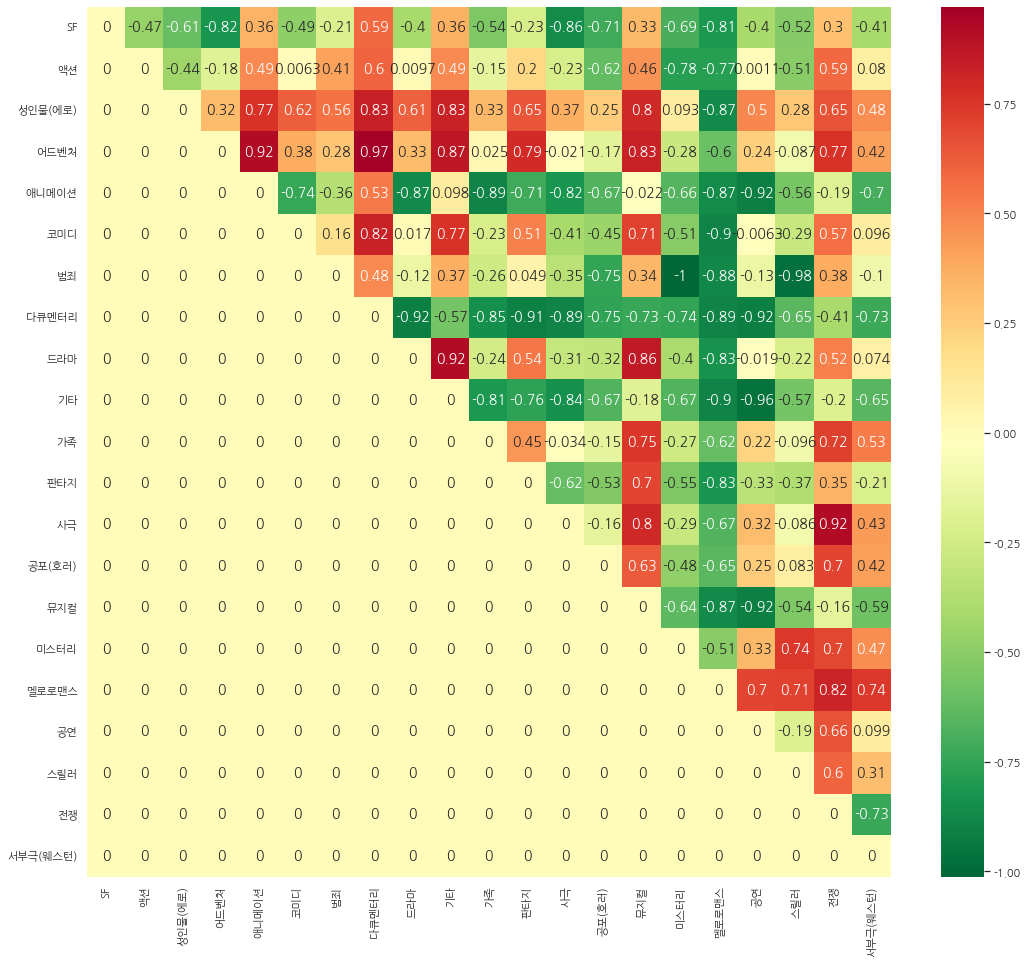

In [ ]:
np.random.seed(0)

sns.set(font='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (18, 16)
ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r', annot_kws={'size': 14})
ticks = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

<br/>

WEAT Score를 Heatmap 형태로 시각화한다.
<br/>편향성이 두드러지는 영화장르 attribute 구성에는 어떤 케이스가 있는지 시각적으로 두드러지게 구성한다.

#결론

#참고문헌

<br/>**LMS**
<br/>yjseraphina89

<br/>**공식 사이트**
<br/>[KOBIS(영화관입장권통합전산망) 영화정보](https://www.kobis.or.kr/kobis/business/mast/mvie/searchMovieList.do)

<br/>**깃허브**
<br/>[(G6)WEAT Project.ipynb](https://github.com/Jeongeun-Kwak/GD/blob/master/(G6)%20WEAT%20Project.ipynb)
<br/>[GoingDeeper NLP 06 임베딩 내 편향성 알아보기_프로젝트](https://piaojian.tistory.com/37)

<br/>**웹사이트**
<br/>[구글 코랩(colab) 한글 깨짐 현상 해결방법](https://teddylee777.github.io/colab/colab-korean)
<br/>[Hide text before seaborn barplot duplicate](https://stackoverflow.com/questions/57165540/hide-text-before-seaborn-barplot)

<br/>**공부**
<br/>[Python 영화진흥위원회 상영관 데이터 웹크롤링](https://littleworks.tistory.com/3)
<br/>[python 크롤링 및 개인프로젝트 시작](https://angehende-ingenieur.tistory.com/180)
<br/>[KOFIC(영화진흥위원회) 영화상세정보 조회 API 서비스](https://www.kobis.or.kr/kobisopenapi/homepg/apiservice/searchServiceInfo.do)
<br/>[파이썬으로 영화오픈API파싱](https://yeowool0217.tistory.com/550)
<br/>[영화진흥위원회 오픈API 사용하는 방법 + csv 추출](https://fjdkslvn.tistory.com/27)